In [1]:
import os
import sys
import requests
import pandas as pd
import numpy as np
import QuantLib as ql
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime
from datetime import timedelta
from model_settings import ms
from historical_av_plot_vol_surface import plot_vol_surface

symbol='SPY'
url = str(
	'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+
	symbol+'&outputsize=full&apikey='+
	ms.av_key)
r = requests.get(url)
spots = pd.Series(pd.DataFrame(r.json()['Time Series (Daily)']).transpose()['4. close'].squeeze())
spots = pd.to_numeric(spots,errors='coerce')
print(spots)


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual

2024-10-11    579.5800
2024-10-10    576.1300
2024-10-09    577.1400
2024-10-08    573.1700
2024-10-07    567.8000
                ...   
1999-11-05    137.8750
1999-11-04    136.5312
1999-11-03    135.5000
1999-11-02    134.5937
1999-11-01    135.5625
Name: 4. close, Length: 6277, dtype: float64


# example data collection

let us collect a few recent trading days and inspect the data

In [2]:
dates = spots.index
dates = dates[:10]
for date in dates:
    print(date)

2024-10-11
2024-10-10
2024-10-09
2024-10-08
2024-10-07
2024-10-04
2024-10-03
2024-10-02
2024-10-01
2024-09-30


In [3]:
from historical_alphaVantage_collection import collect_av_link
chain = {}
for date in dates:
    spot = float(spots[date])
    link = collect_av_link(date,spot,symbol)
    printdate = datetime.strptime(date, '%Y-%m-%d').strftime('%A, %Y-%m-%d')
    chain[date] = link

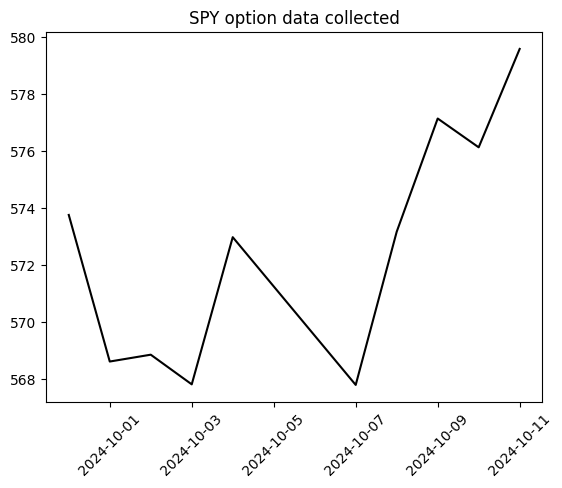

<Figure size 640x480 with 0 Axes>

In [4]:
demo_spots = spots[dates]
demo_spots.index = pd.to_datetime(demo_spots.index, format='%Y-%m-%d')
plt.figure()
plt.plot(demo_spots,color='black')
plt.title(f'{symbol} option data collected')
plt.xticks(rotation=45)
plt.show()
plt.clf()

# example calibraion

now why not select the one trading day and porceed with an example calibration of our Heston (1993) model

In [5]:
date = dates[3]
raw_data = chain[date]
calculation_datetime = datetime.strptime(date,'%Y-%m-%d')
calculation_date = ql.Date(
    calculation_datetime.day,
    calculation_datetime.month,
    calculation_datetime.year,
)
print(str(calculation_datetime.strftime('%A, '))+str(calculation_date))

Tuesday, October 8th, 2024


## modelling the volatility surface

In [6]:
df = raw_data.copy()
columns_to_convert = ['strike', 'last', 'mark',
       'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest',
       'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho']
df[columns_to_convert] = df[
    columns_to_convert].apply(pd.to_numeric, errors='coerce')

df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['days_to_maturity'] = df['expiration'] - df['date']
df['days_to_maturity'] = df['days_to_maturity'] / np.timedelta64(1, 'D')
df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]

df = df[df['volume']>0].copy()
df['spot_price'] = spot

df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
indexed = df.copy().set_index(['strike','days_to_maturity'])

T = np.sort(df['days_to_maturity'].unique()).tolist()
K = np.sort(df['strike'].unique()).tolist()
volume_heatmap = pd.DataFrame(
    np.full((len(K), len(T)), np.nan), index=K, columns=T)
for k in K:
    for t in T:
        try:
            volume_heatmap.loc[k,t] = indexed.loc[(k,t),'volume']
        except Exception:
            pass
        
        
hottest_contracts = pd.DataFrame(
    volume_heatmap.unstack().sort_values(
        ascending=False)).head(50).reset_index()
hottest_contracts.columns = ['t','k','volume']
T = np.sort(hottest_contracts['t'].unique()).tolist()
K = np.sort(hottest_contracts['k'].unique()).tolist()

vol_matrix = pd.DataFrame(
    np.full((len(K),len(T)),np.nan),
    index = K,
    columns = T
)
for k in K:
    for t in T:
        try:
            vol_matrix.loc[k,t] = indexed.loc[(k,float(t)),'implied_volatility']
        except Exception:
            pass

vol_matrix = vol_matrix.dropna().copy()
T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()

cols_to_map = [
        'contractID', 'symbol', 'expiration', 'type', 'last', 'mark',
        'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest', 'date',
        'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho',
        'spot_price', 'moneyness'
]
for col in cols_to_map:
    for i,row in hottest_contracts.iterrows():
        hottest_contracts.at[i,col] = indexed.loc[(row['k'],row['t']),col]
        
hottest_contracts = hottest_contracts.rename(
    columns={'t':'days_to_maturity','k':'strike_price'}).copy()

link = {
        'raw_data': raw_data,
        'surface': vol_matrix,
        }


SPY spot price: 573.76

           31       38       52       73       84       101      115      164  \
500.0  0.31159  0.29803  0.27851  0.26617  0.25839  0.25336  0.24940  0.24071   
510.0  0.29117  0.27928  0.26144  0.25199  0.24513  0.24086  0.23751  0.23095   
520.0  0.27013  0.26098  0.24544  0.23827  0.23217  0.22882  0.22608  0.22120   
525.0  0.26083  0.25199  0.23781  0.23156  0.22577  0.22288  0.22013  0.21632   
530.0  0.25138  0.24330  0.23004  0.22486  0.21983  0.21693  0.21464  0.21160   
540.0  0.23278  0.22608  0.21495  0.21160  0.20718  0.20519  0.20352  0.20199   
550.0  0.21495  0.20931  0.20016  0.19818  0.19452  0.19330  0.19239  0.19254   
555.0  0.20580  0.20077  0.19254  0.19147  0.18812  0.18751  0.18690  0.18797   
560.0  0.19650  0.19224  0.18492  0.18461  0.18187  0.18187  0.18157  0.18355   
565.0  0.18705  0.18340  0.17745  0.17791  0.17577  0.17608  0.17623  0.17928   
570.0  0.17776  0.17471  0.16998  0.17166  0.16968  0.17090  0.17120  0.17516   
575

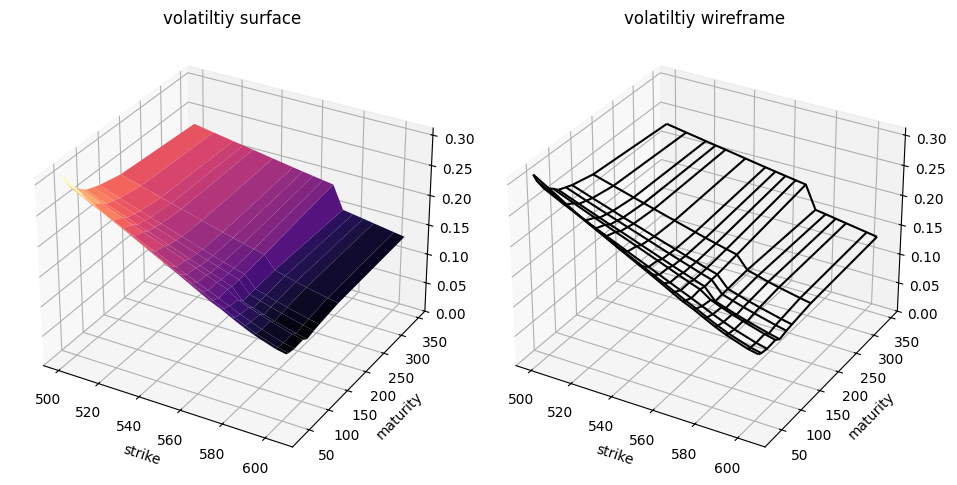

<Figure size 640x480 with 0 Axes>

In [7]:
vol_matrix = link['surface']
s = float(df['spot_price'].unique()[0])
print(f"\n{symbol} spot price: {s}")
print(f"\n{vol_matrix}\n")
plot_vol_surface(vol_matrix)

## calibrating a Heston (1993) model

In [8]:
vol_matrix = vol_matrix.sort_index().drop_duplicates()
pd.to_numeric(raw_data['last'])
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['expiration'] = pd.to_datetime(raw_data['expiration'])
raw_data['implied_volatility'] = pd.to_numeric(raw_data['implied_volatility']).astype(float)
raw_data['strike'] = pd.to_numeric(raw_data['strike'])
raw_data['last'] = pd.to_numeric(raw_data['last'])
contract_maturities = np.array((raw_data['expiration'] - raw_data['date']) / timedelta(days=1)).astype(int)
raw_data['days_to_maturity'] = contract_maturities

T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()
r = 0.04
g = 0.0

ql.Settings.instance().evaluationDate = calculation_date
flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
S_handle = ql.QuoteHandle(ql.SimpleQuote(s))

heston_helpers = []
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
process = ql.HestonProcess(
    flat_ts,
    dividend_ts,
    S_handle,
    v0,                # Initial volatility
    kappa,             # Mean reversion speed
    theta,             # Long-run variance (volatility squared)
    eta,               # Volatility of the volatility
    rho                # Correlation between asset and volatility
)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

for t in T:
    for k in K:
        p = ql.Period(int(t),ql.Days)
        volatility = vol_matrix.loc[k,t]
        helper = ql.HestonModelHelper(
            p, ms.calendar, float(s), k, 
            ql.QuoteHandle(ql.SimpleQuote(volatility)), 
            flat_ts, 
            dividend_ts
            )
        helper.setPricingEngine(engine)
        heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)


model.calibrate(heston_helpers, lm,
                  ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, eta, rho, v0 = model.params()
heston_parameters = pd.Series(
    [theta, kappa, eta, rho, v0],
    index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
    dtype = float
)
calibration_test_data = raw_data.copy()[['strike','type','last','implied_volatility','days_to_maturity']]
calibration_test_data.columns = ['strike_price','w','market_price','volatility','days_to_maturity']
calibration_test_data['spot_price'] = s
calibration_test_data['risk_free_rate'] = r
calibration_test_data['dividend_rate'] = g
calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
    calibration_test_data['spot_price'].values,
    calibration_test_data['strike_price'].values,
    calibration_test_data['w'].values)
calibration_test_data['calculation_date'] = calculation_datetime
calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)

## testing calibration accuracy

In [9]:
calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values - calibration_test_data['black_scholes'].values
avg = np.mean(np.abs(calibration_test_data['error']))
print(f"\n{printdate}\n{heston_parameters}\naverage absolute error: {round(avg,3)}")
print(f"calibration testing dataset:\n{calibration_test_data.describe()}")


Monday, 2024-09-30
theta    0.128750
kappa    0.507891
eta      1.326914
rho     -0.723443
v0       0.038301
dtype: float64
average absolute error: 2.627
calibration testing dataset:
       strike_price  market_price   volatility  days_to_maturity  \
count   4946.000000   4946.000000  4946.000000       4946.000000   
mean     516.437525     41.852331     0.249732        163.988273   
min      120.000000      0.000000     0.012760         31.000000   
25%      454.000000      0.000000     0.164875         73.000000   
50%      528.000000      6.140000     0.211365        143.000000   
75%      585.000000     55.582500     0.292690        265.000000   
max      830.000000    451.670000     1.349070        357.000000   
std      125.840010     71.700001     0.145537        108.548043   

         spot_price  risk_free_rate  dividend_rate       theta         kappa  \
count  4.946000e+03         4946.00         4946.0  4946.00000  4.946000e+03   
mean   5.737600e+02            0.04        

# train data generation

In [10]:
K = np.linspace(s*0.8,s*1.2,7).astype(int).tolist()
down_barriers =  np.linspace(s*0.5,s*0.99,5).astype(int).tolist()
T = [
    30,60,90,
    180,360,540,720
]
print(f"\n{symbol} spot price:\n     {spot}\nstrikes:\n     {K}\n\nbarriers:\n     {down_barriers}\n\nmaturities:\n     {T}\n")


SPY spot price:
     573.76
strikes:
     [459, 497, 535, 573, 612, 650, 688]

barriers:
     [286, 357, 427, 497, 568]

maturities:
     [30, 60, 90, 180, 360, 540, 720]



In [11]:
features = pd.DataFrame(
    product(
        [spot],
        K,
        T,
        down_barriers,
        [0.0], # rebate
        ['put','call'],
        [0.04], # risk-free rate
        [0.0], # dividend rate
        [theta], 
        [kappa], 
        [eta], 
        [rho], 
        [v0],
        [calculation_datetime],
        ['Out','In']
    ),
    columns = [
        'spot_price',
        'strike_price',
        'days_to_maturity',
        'barrier',
        'rebate',
        'w',
        'risk_free_rate',
        'dividend_rate',
        'theta', 'kappa', 'eta', 'rho', 'v0',
        'calculation_date',
        'outin',
    ]
)
features['moneyness'] = ms.vmoneyness(features['spot_price'],features['strike_price'],features['w'])
features['barrier_type_name'] = 'Down' + features['outin']
features['vanilla_price'] = ms.vector_heston_price(features)
features['barrier_price'] = ms.vector_barrier_price(features)
featuresby_t = features.copy().set_index('days_to_maturity')

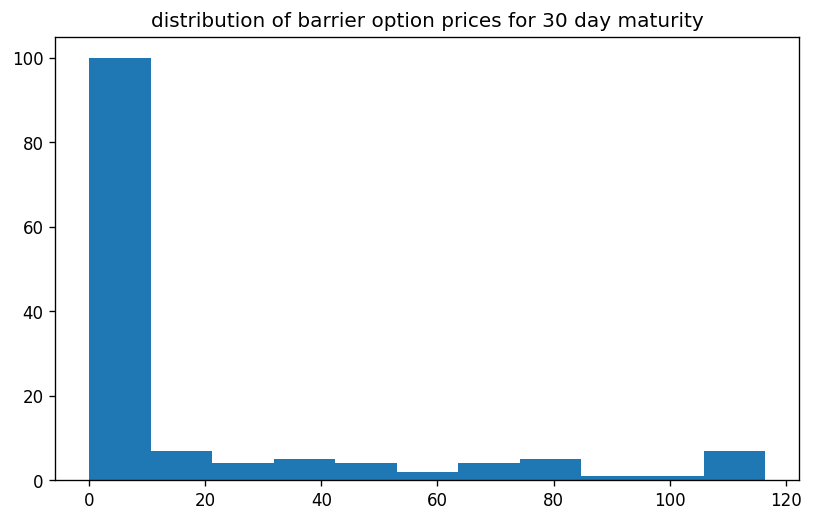

<Figure size 640x480 with 0 Axes>

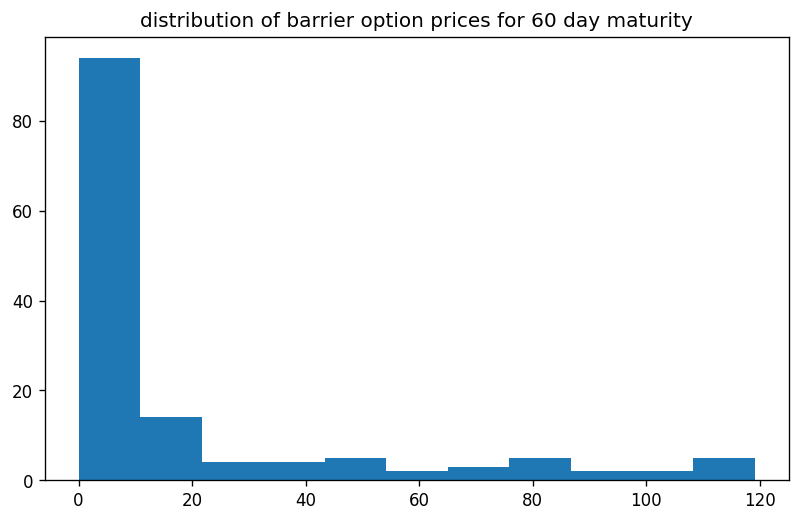

<Figure size 640x480 with 0 Axes>

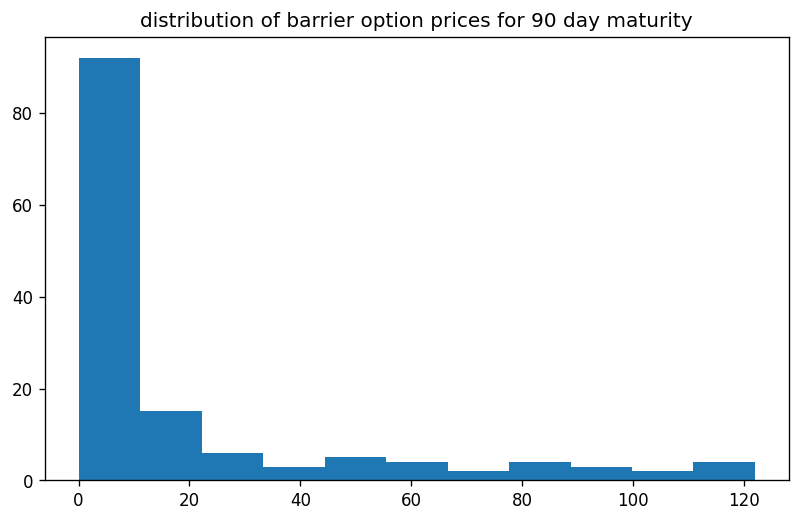

<Figure size 640x480 with 0 Axes>

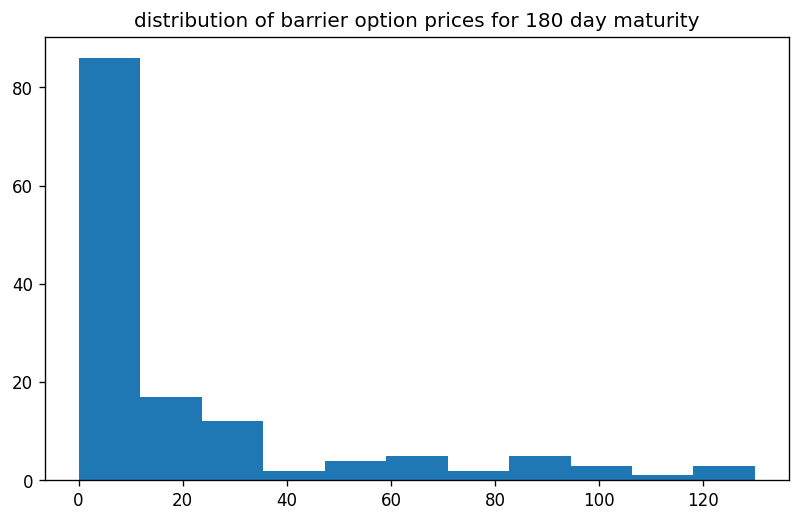

<Figure size 640x480 with 0 Axes>

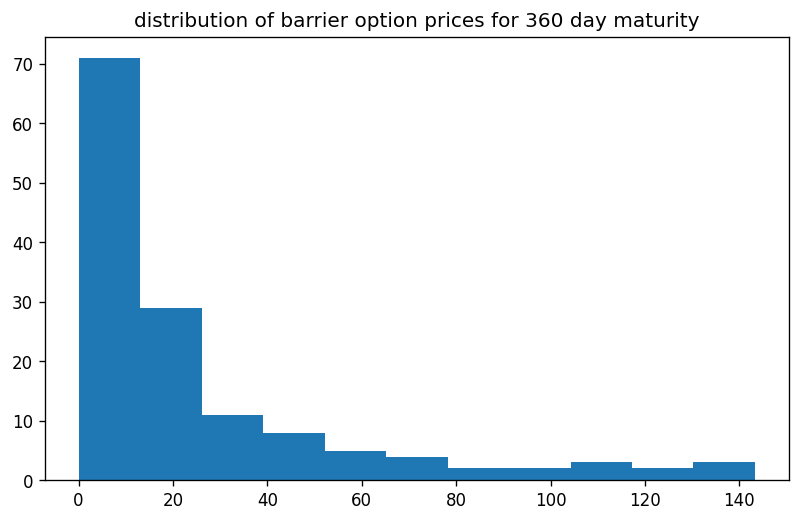

<Figure size 640x480 with 0 Axes>

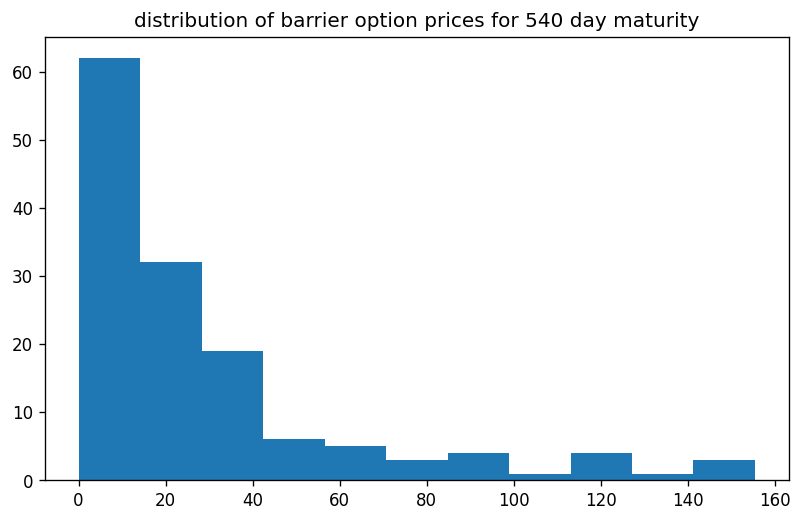

<Figure size 640x480 with 0 Axes>

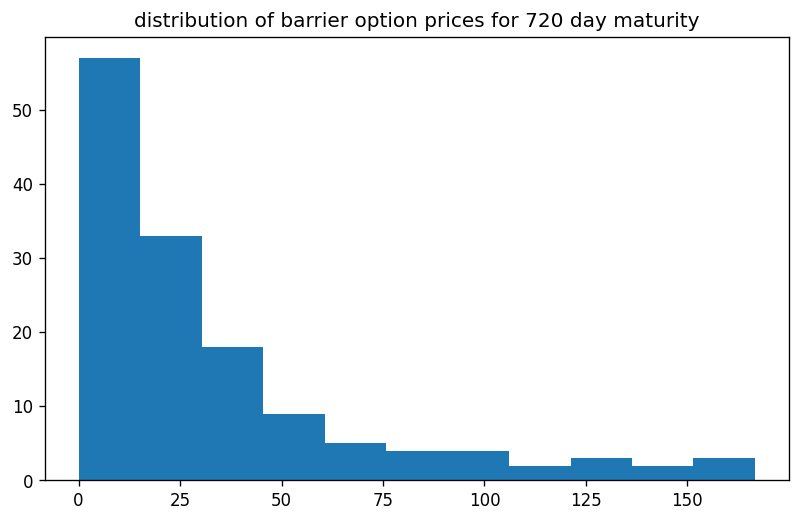

<Figure size 640x480 with 0 Axes>

In [12]:
for t in T:
    plt.figure(figsize=plt.figaspect(0.6),dpi=120)
    prices= featuresby_t.loc[t,'barrier_price']
    plt.hist(prices,bins=int(np.sqrt(prices.shape[0])))
    plt.title(f'distribution of barrier option prices for {t} day maturity')
    plt.show()
    plt.clf()

# model training

In [13]:
from convsklearn import barrier_trainer
bt = barrier_trainer

test size: 1.0%
random state: None
maximum iterations: 1000

target: 
observed_price

features: 
['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier', 'barrier_type_name', 'w']

feature transformer(s):
('StandardScaler', StandardScaler(), ['spot_price', 'strike_price', 'days_to_maturity', 'risk_free_rate', 'dividend_rate', 'kappa', 'theta', 'rho', 'eta', 'v0', 'barrier'])

('OneHotEncoder', OneHotEncoder(sparse_output=False), ['barrier_type_name', 'w'])

target transformer(s):
StandardScaler()



In [15]:
features['observed_price'] = ms.noisyfier(features.loc[:,'barrier_price']) # apply slight peturbation in the form of a random normal with standard deviation 0.15
train_data = features[features['days_to_maturity']!=720]
test_data = features[features['days_to_maturity']==720]
arrs = bt.get_train_test_arrays(train_data,test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['train_y']
preprocessor = bt.preprocess()
dnn_barriers, runtime, specs = bt.run_dnn(preprocessor, train_X, train_y)
insample, outsample, errors = bt.test_prediction_accuracy(dnn_barriers, test_data, train_data)
print(dnn_barriers)
print(outsample)


training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001

in sample:
     RSME: 7.7295195806531405
     MAE: 5.056006552160728

out of sample:
     RSME: 13.826936968647077
     MAE: 9.877072255579307
TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                     